**Data soure form : https://www.kaggle.com/datasets/itsmesunil/bank-loan-modelling**

### * *Feature **

*   ID : Customer ID
*   Age : Customer's age in completed years
*   Experience : years of professional experience
*   Income : Annual income of the customer (dollar)
*   ZIPCode : Home Address ZIP code
*   Family : Family size of the customer
*   CCAvg : Avg. spending on credit cards per month (dollar)
*   Education : Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional
*   Mortgage : Value of house mortgage if any. (dollar)
*   Securities Account : Does the customer have a securities account with the bank?
*   CD Account : Does the customer have a certificate of deposit (CD) account with the bank?
*   Online : Does the customer use internet banking facilities?
*   CreditCard : Does the customer use a credit card issued by UniversalBank?


---


### ** Target*
*   Personal Loan : Did this customer accept the personal loan offered in the last



---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import KFold

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_excel('/content/Bank_Personal_Loan_Modelling.xlsx')

In [4]:
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


# EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [6]:
df = df.drop(columns=['ID','ZIP Code'])

In [7]:
df.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


In [8]:
df.isnull().sum()

,0
Age,0
Experience,0
Income,0
Family,0
CCAvg,0
Education,0
Mortgage,0
Personal Loan,0
Securities Account,0
CD Account,0


In [9]:
df.duplicated().sum()

13

In [10]:
df=df.drop_duplicates()

In [11]:
df.nunique()

,0
Age,45
Experience,47
Income,162
Family,4
CCAvg,108
Education,3
Mortgage,347
Personal Loan,2
Securities Account,2
CD Account,2


In [12]:
num_cols = []
cat_cols = []
for col in df.columns:
    if df[col].nunique() > 5:
        num_cols.append(col)
    else:
        cat_cols.append(col)

print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)

num_cols = df[num_cols]
cat_cols = df[cat_cols]

Numerical columns: ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']
Categorical columns: ['Family', 'Education', 'Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']


## Box plot

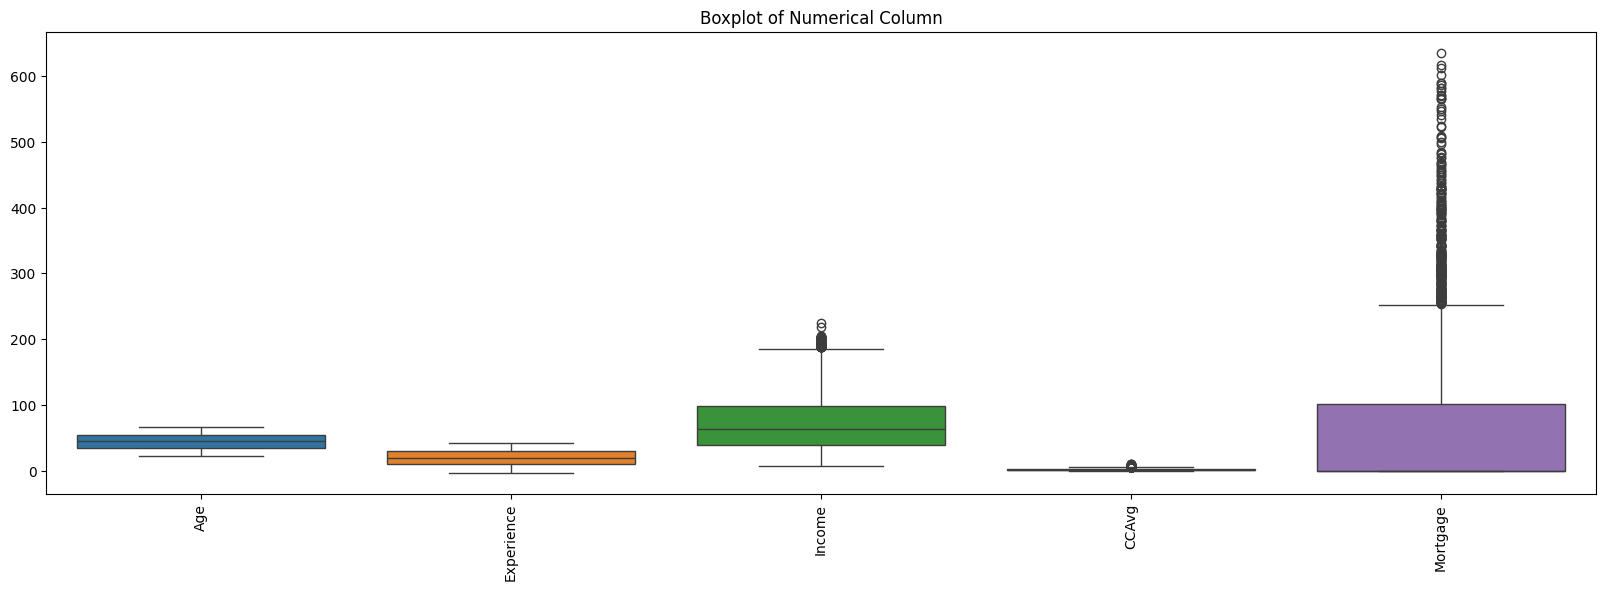

In [13]:
plt.figure(figsize=(20, 6))
sns.boxplot(num_cols)
plt.xticks(rotation=90)
plt.title("Boxplot of Numerical Column")
plt.show()

## Check Class Balance

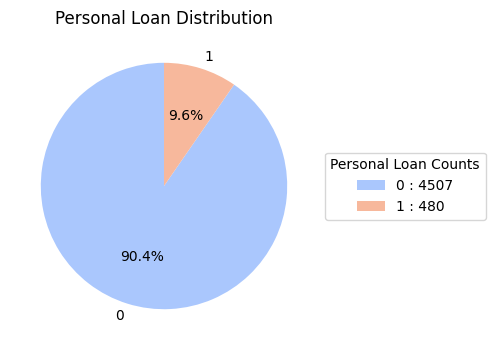

In [14]:
loan_status_counts = df['Personal Loan'].value_counts()

plt.figure(figsize=(6,4 ))
plt.pie(loan_status_counts, labels=loan_status_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("coolwarm", len(loan_status_counts)))
plt.title('Personal Loan Distribution')

legend_labels = [f'{label} : {count}' for label, count in zip(loan_status_counts.index, loan_status_counts.values)]
plt.legend(legend_labels, title='Personal Loan Counts', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

## Histogram with Continuous Data

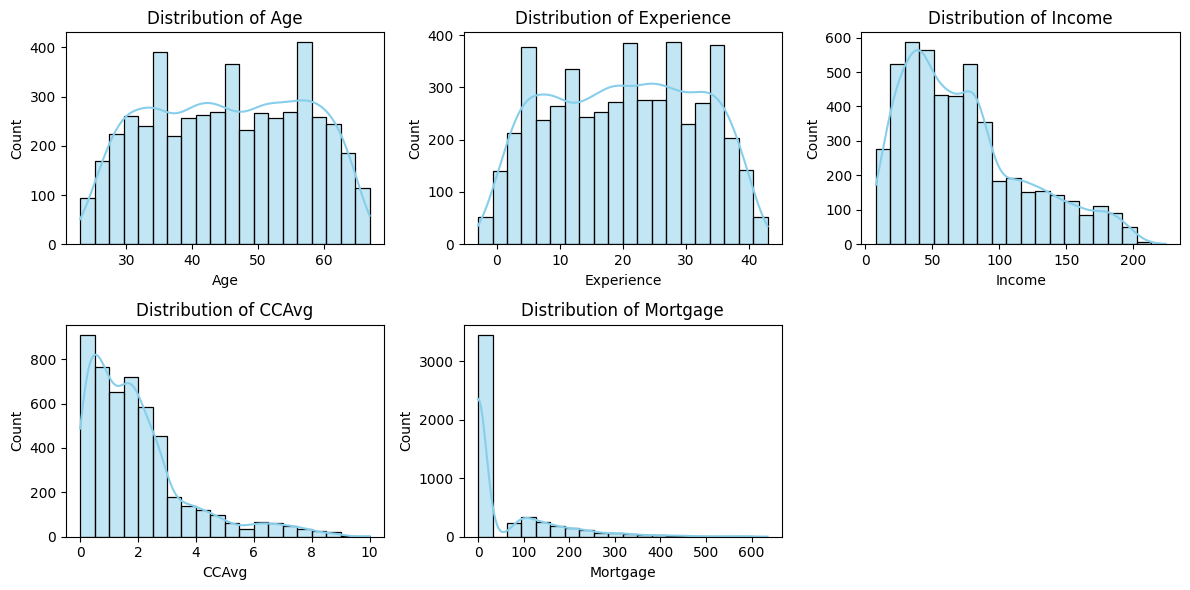

In [15]:
plt.figure(figsize=(12, 6))
for i, col in enumerate(num_cols.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True, bins = 20, color='skyblue')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

## Bar plot with Catagory Data

<ipython-input-16-58fc5586b39c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='coolwarm')
<ipython-input-16-58fc5586b39c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='coolwarm')
<ipython-input-16-58fc5586b39c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='coolwarm')
<ipython-input-16-58fc5586b39c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=F

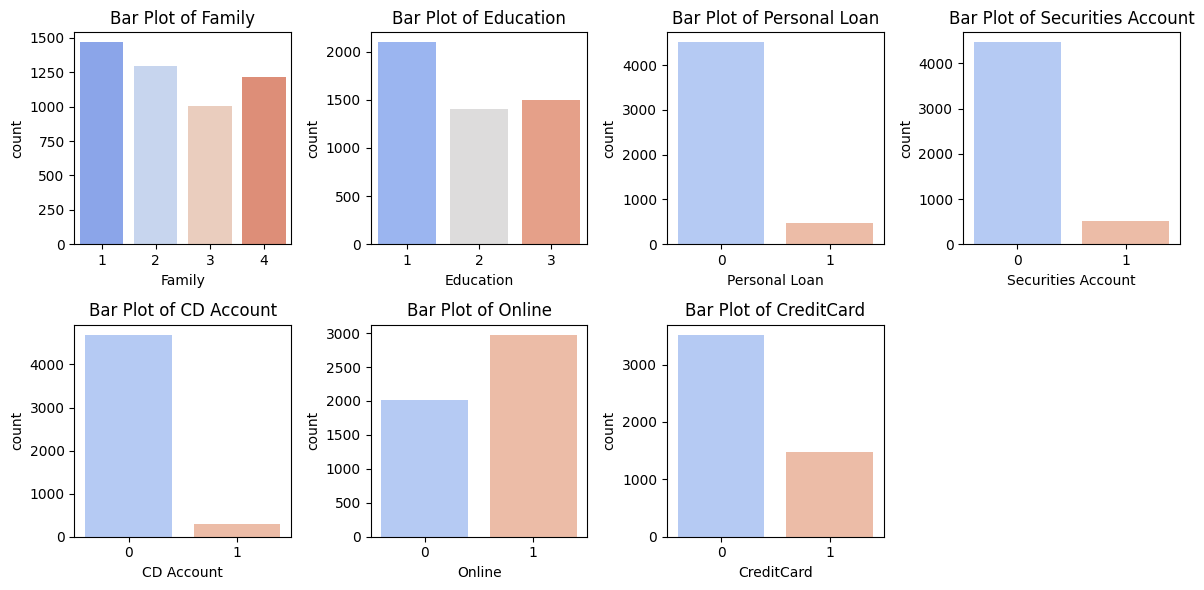

In [16]:
plt.figure(figsize=(12, 6))
for i, col in enumerate(cat_cols.columns):
    plt.subplot(2, 4, i + 1)
    sns.countplot(x=col, data=df, palette='coolwarm')
    plt.title(f'Bar Plot of {col}')
plt.tight_layout()
plt.show()

## Scatter plot with Every variable

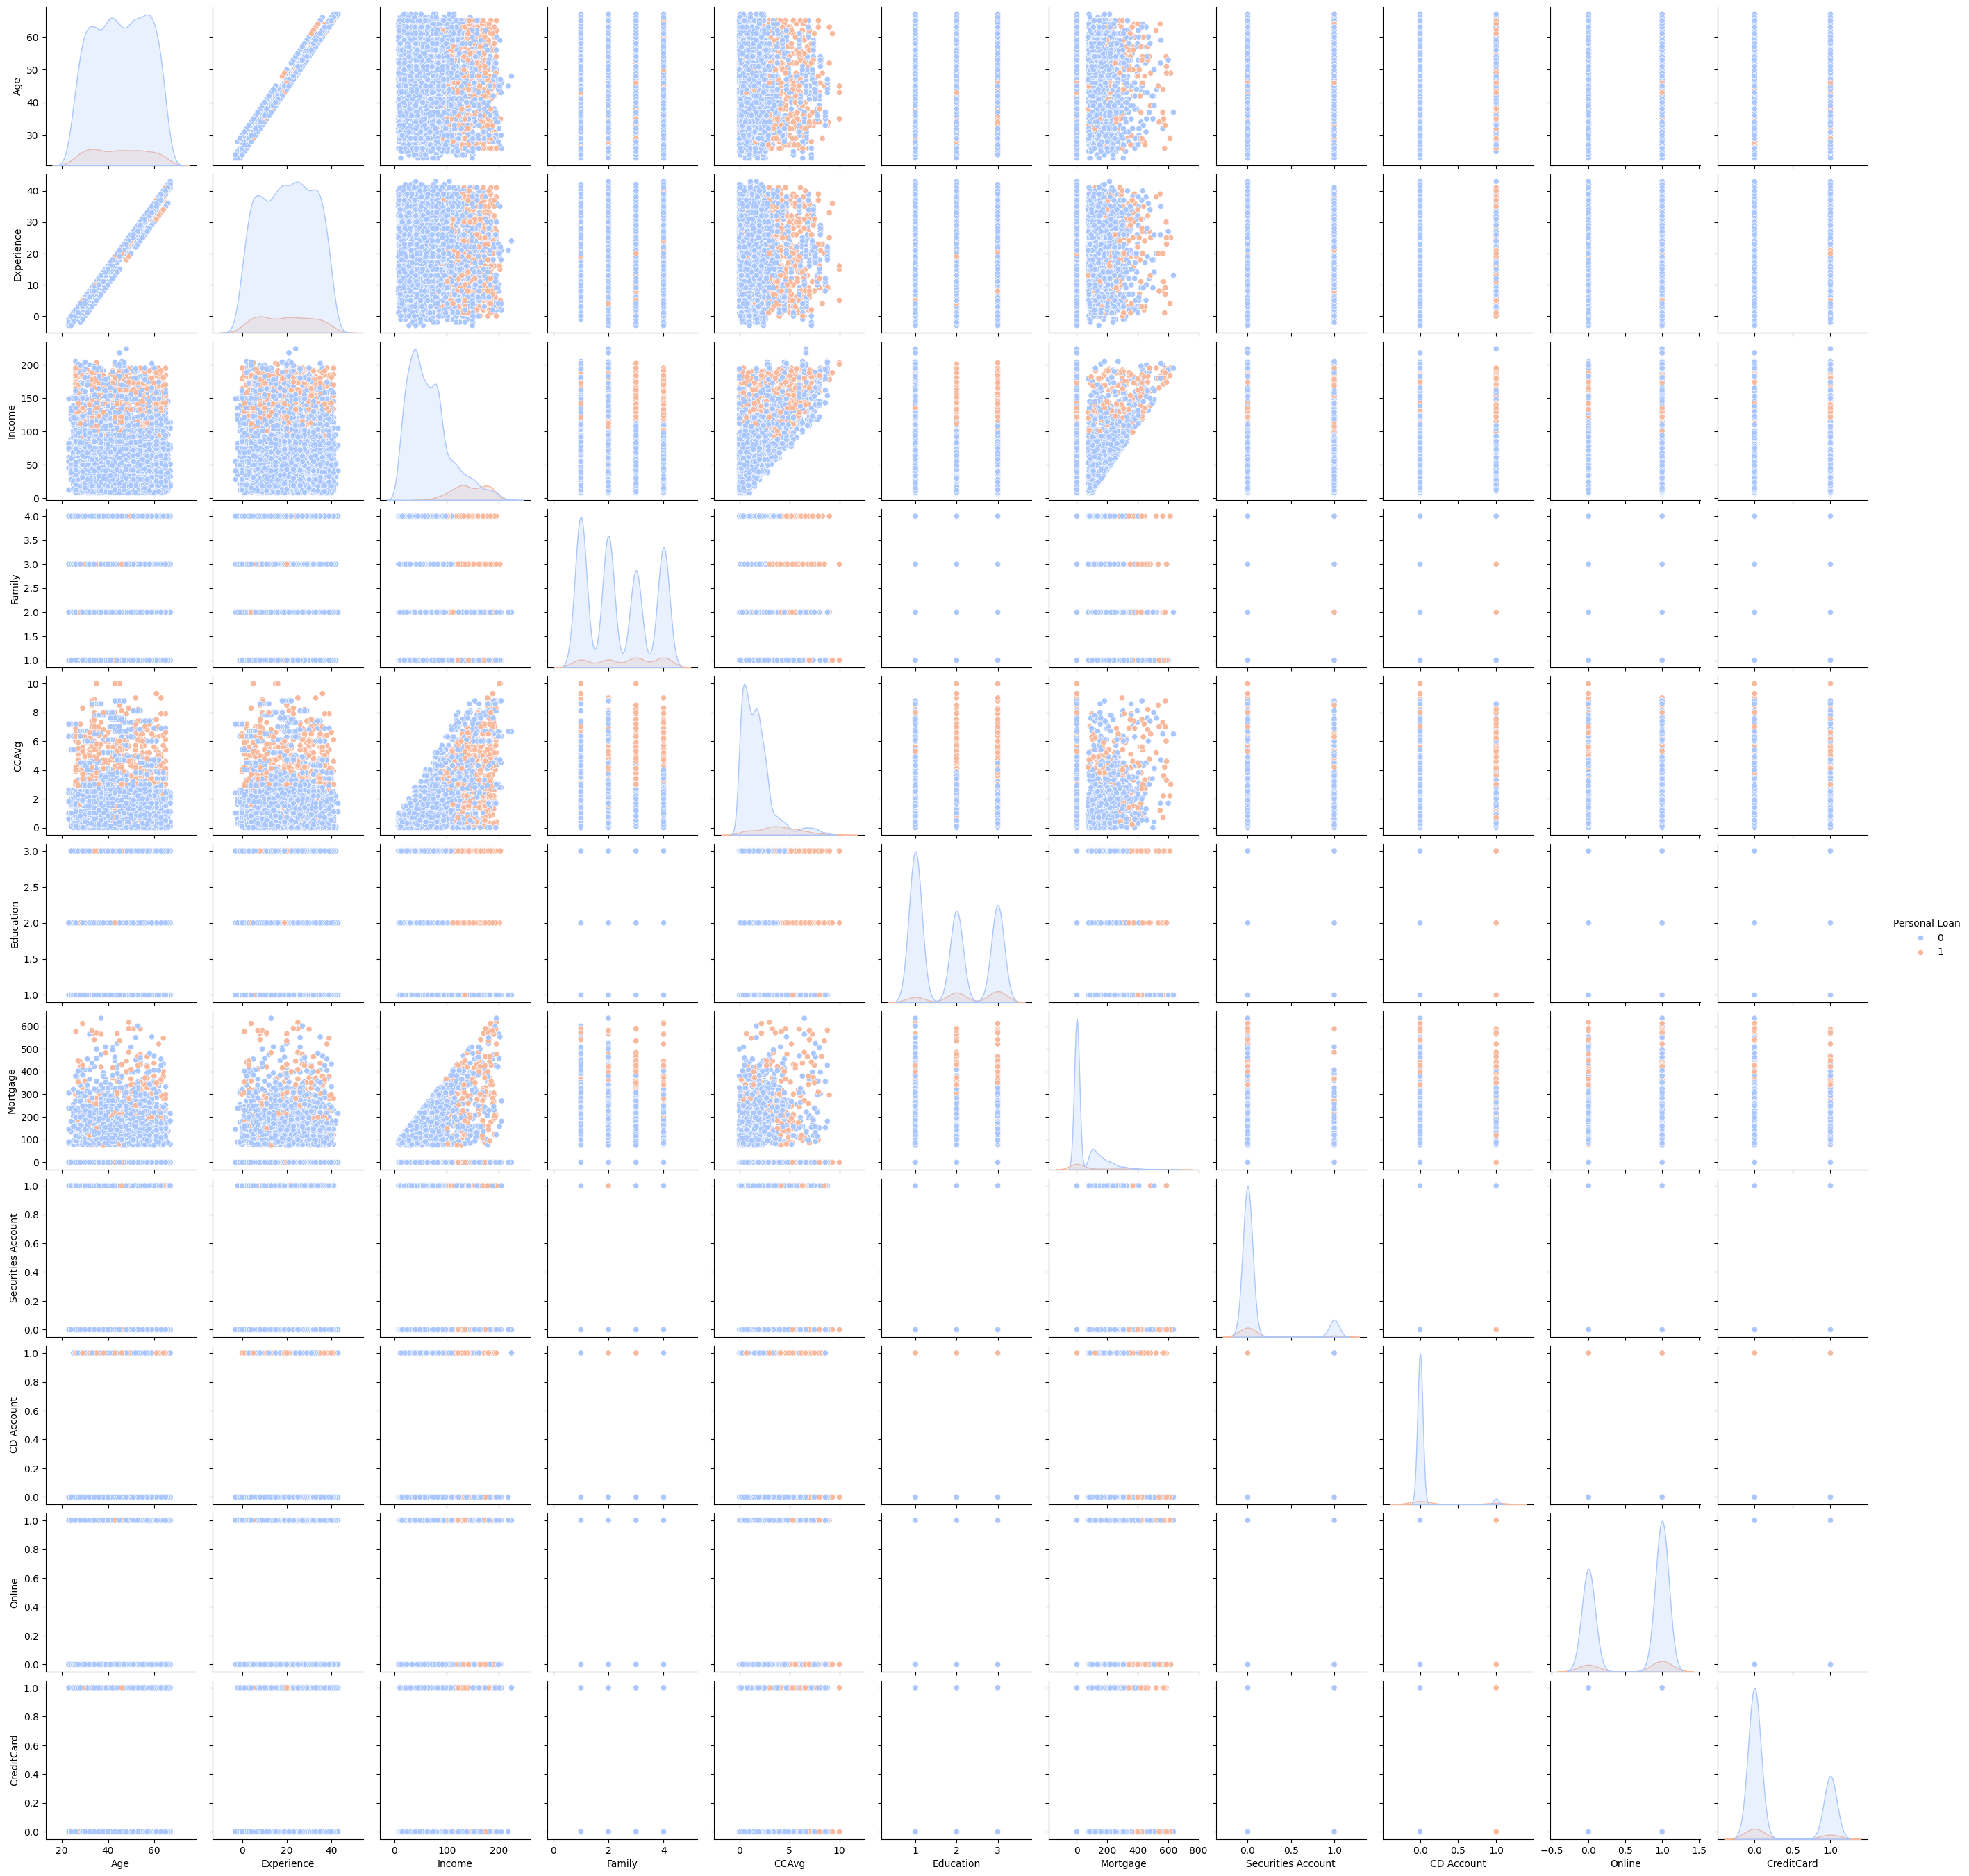

In [17]:
sns.pairplot(df, hue='Personal Loan', palette="coolwarm")
plt.show()

## Heat map (Find correlation)

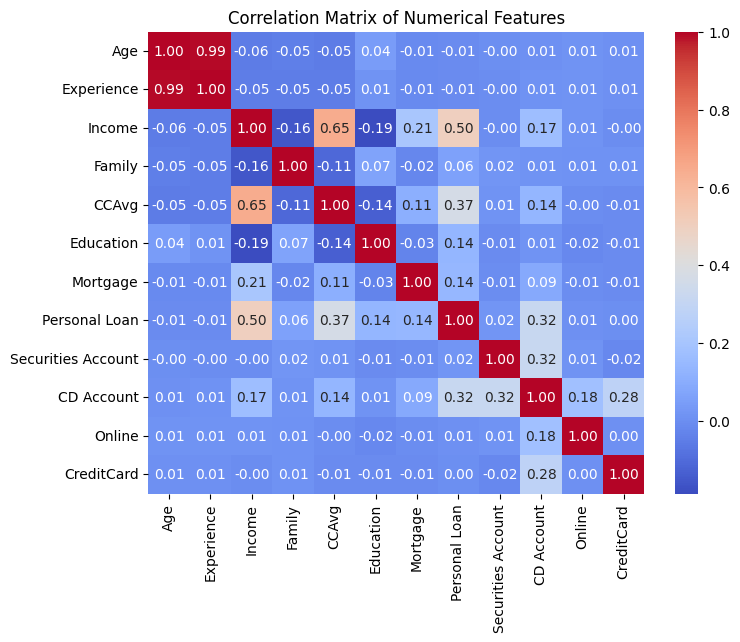

In [18]:
corr_matrix = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# XGBoots

## Select Feature and Target

In [19]:
X = df.drop('Personal Loan', axis=1)
y = df['Personal Loan']

## Under sampling

In [20]:
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("Train: \n",y_train.value_counts())

Train: 
 Personal Loan
0    394
1    374
Name: count, dtype: int64


## Modeling

In [21]:
#!pip install scikit-learn==1.3.1

In [22]:
# Define the parameter grid to find the best value.
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)   #Have to use this version !pip install scikit-learn==1.3.1 #

print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Best score: 0.9804940157881334


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:41:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Result (Confusion Matrix)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       426
           1       1.00      1.00      1.00       438

    accuracy                           1.00       864
   macro avg       1.00      1.00      1.00       864
weighted avg       1.00      1.00      1.00       864



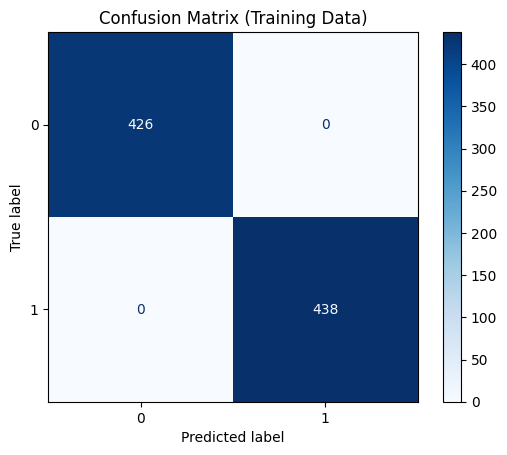

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        54
           1       0.98      1.00      0.99        42

    accuracy                           0.99        96
   macro avg       0.99      0.99      0.99        96
weighted avg       0.99      0.99      0.99        96



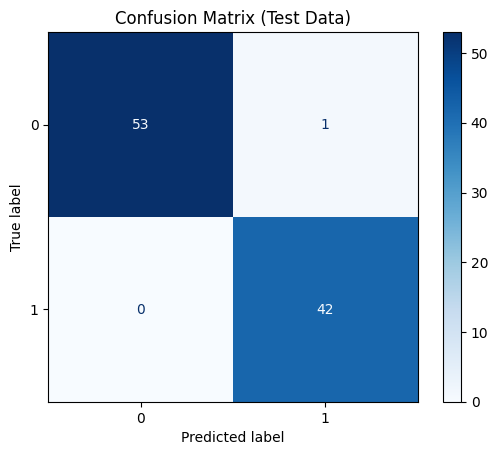

In [25]:
# Train Confusion Matrix
print(classification_report(y_train, best_xgb_model.predict(X_train)))
cm_train = confusion_matrix(y_train, best_xgb_model.predict(X_train))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=best_xgb_model.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Training Data)")
plt.show()

# Test Confusion Matrix
print(classification_report(y_test, y_pred))
cm_test = confusion_matrix(y_test, y_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=best_xgb_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test Data)")
plt.show()

# Validation

In [26]:
accuracy_scores = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    best_xgb_model.fit(X_train, y_train)
    y_pred = best_xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

print("Accuracy scores:", accuracy_scores)
print("Average accuracy:", np.mean(accuracy_scores))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:41:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:41:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:42:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:42:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:42:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Accuracy scores: [0.9895833333333334, 0.9895833333333334, 1.0, 0.9583333333333334, 0.9895833333333334, 0.96875, 0.96875, 0.9791666666666666, 0.9791666666666666, 0.9895833333333334]
Average accuracy: 0.98125
